In [41]:
from __future__ import division
import cv2
from matplotlib import pyplot as plt
import numpy as np
from math import cos,sin


In [42]:
#defining green globally
green = (0,255,0)

#showing image
def show(image):
    #figure size in inches
    plt.figure(figsize=(10,10))
    plt.imshow(image,interpolation='nearest')
    
#overlaying mask
def overlay_mask(mask,image):
    #make mask rgb
    rgb_mask= cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    #Adding two matrices so ask to overlay mask on the image
    img = cv2.addWeighted(rgb_mask,0.5,image,0.5,0)
    return img

#finding viggest contour
def find_biggest_contour(image):
    #copy image
    image = image.copy()
    #we only need end points of the contour and not everything. so taking 
    #all horizontal,vertical and diagonal parts of the matrix and then taking the approximation
    #So we are trying to retrieving this list
    image, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    #Get the area of all the contours and store it in contour_sizes array
    contour_sizes = [(cv2.contourArea(contour),contour) for contour in contours]
    #Get biggest size, and put the value in the 1st position
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    
    #return the biggest contour
    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1,255,-1)
    return biggest_contour, mask

#Defining actual contour
def circled_contour(image,contour):
    #bounding ellipse
    image_with_ellipse = image.copy()
    ellipse = cv2.fitEllipse(contour)
    
    #add it
    #2 is width of contour line
    cv2.ellipse(image_with_ellipse, ellipse, green, 2, cv2.LINE_AA)
    return image_with_ellipse
    
def find_strawberry(image):
    #BGR Blue occupies least area, so it's about bytes,memory and ordering
    #RGB is always better so convertinf to RGB
    #Orders of the colors in the memory
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    #Now scaling image properly
    max_dimension = max(image.shape)
    #scaling it to max window size which we are gonna use is 700/660 pixels
    scale = 700/max_dimension
    #resizing image to square
    image = cv2.resize(image,None,fx=scale,fy=scale)
    
    #Now cleaning the image
    #To get clean smooth image by taking it across Gaussian distribution
    #kernel size is 7,7. Filtering is 0(as gaussian already does that)
    image_blur = cv2.GaussianBlur(image, (7,7),0)
    #Now convert to hsv format. Seperating color from brightness or intensity
    image_blur_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    #Defining filters
    #Filtering by color first - So if it is more or less red than that, it's not strawberry.
    #Define min and max rage of redness
    min_red = np.array([0,100,80])
    max_red = np.array([10,256,256])
    #Focussing on one color and ignoring everything else, we use mask
    #filtering by hsv and not by color
    mask1 = cv2.inRange(image_blur_hsv,min_red,max_red)
    
    #filter by brightness
    min_red2 = np.array([170,100,80])
    max_red2 = np.array([180,256,256])
    mask2 = cv2.inRange(image_blur, min_red2,max_red2)
    
    #taking these two masks and combining masks
    mask = mask1 + mask2
    
    #Segmentation
    #We first draw an ellipse around the strawberry so that it exactly fits
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    #smaller circles will be created which we will need to clean and remove to get a smooth ellipse
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel)
    
    #Now find the biggest strawberry
    big_strawberry_contour, mask_strawberries = find_biggest_contour(mask_clean)
    
    #Overlay the mask that we created on the image
    overlay = overlay_mask(mask_clean, image)
    #Circle biggest strawberry
    circled = circled_contour(overlay, big_strawberry_contour)
    show(circled)
    
    #Convert image back to original color scheme
    bgr = cv2.cvtColor(circled,cv2.COLOR_RGB2BGR)
    
    return bgr
    

True

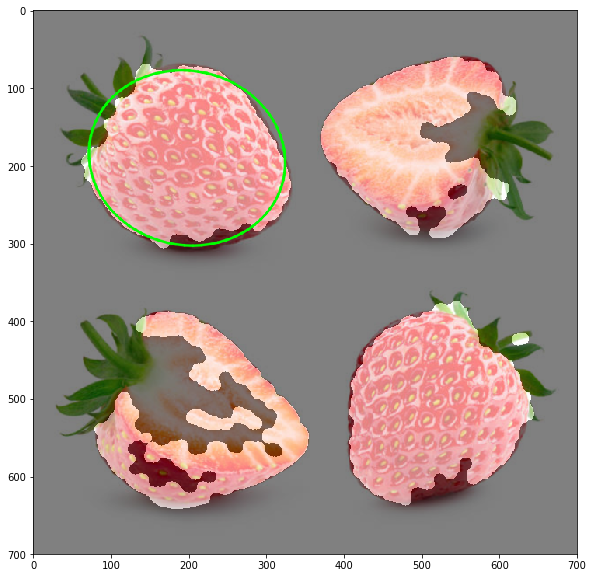

In [43]:
#read the image
image = cv2.imread('/Users/vipanchichacham/Desktop/strawberry.jpg')
result = find_strawberry(image)
#write the new image
cv2.imwrite('/Users/vipanchichacham/Desktop/strawberry1.jpg', result)